## Forecasting the stock price of Amazon using ARIMA model (from 2019-2023)

In [30]:
import os
import warnings
warnings.filterwarnings('ignore')
from pandas_datareader import data as pdr
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [31]:
yf.pdr_override() 
df_amazon = pdr.get_data_yahoo("AMZN", start="2019-01-01", end="2023-09-30")

[*********************100%%**********************]  1 of 1 completed


In [32]:
df_amazon.shape

(1195, 6)

In [33]:
df_amazon.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-25,129.360001,131.779999,128.770004,131.270004,131.270004,46017800
2023-09-26,130.119995,130.389999,125.279999,125.980003,125.980003,73048200
2023-09-27,125.760002,127.480003,124.129997,125.980003,125.980003,66553400
2023-09-28,124.040001,126.580002,123.040001,125.980003,125.980003,54555000
2023-09-29,128.199997,129.149994,126.320000,127.120003,127.120003,62377600


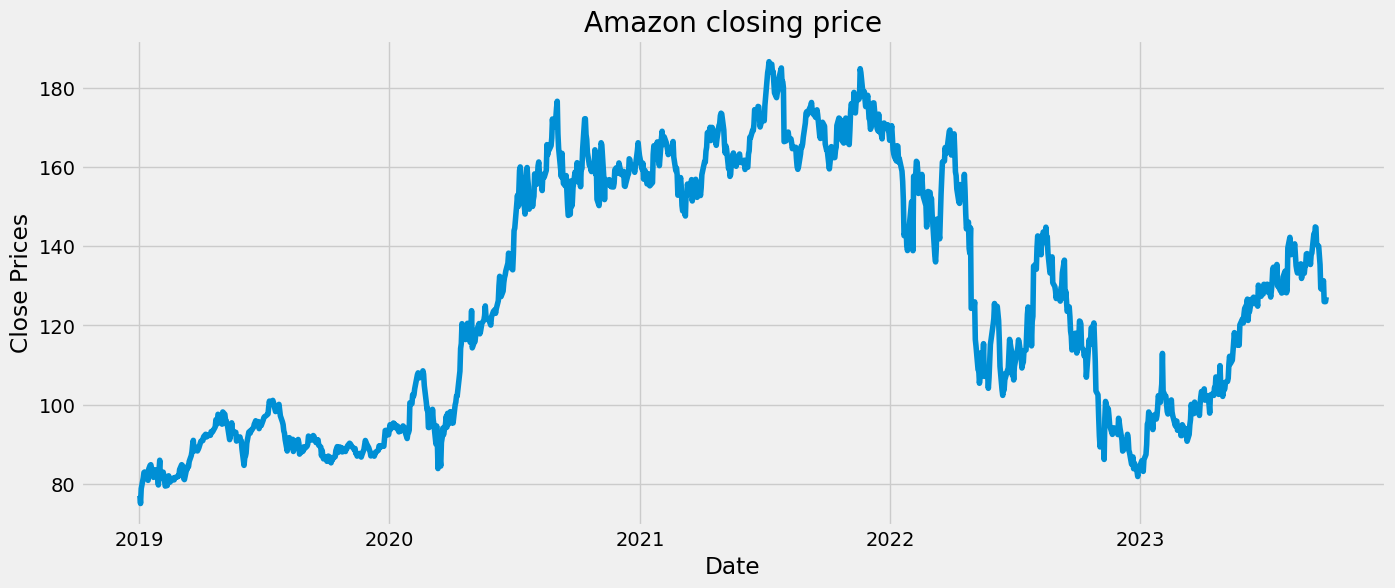

In [35]:
#plot close price
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_amazon['Close'])
plt.title('Amazon closing price')
plt.show()

<Axes: ylabel='Density'>

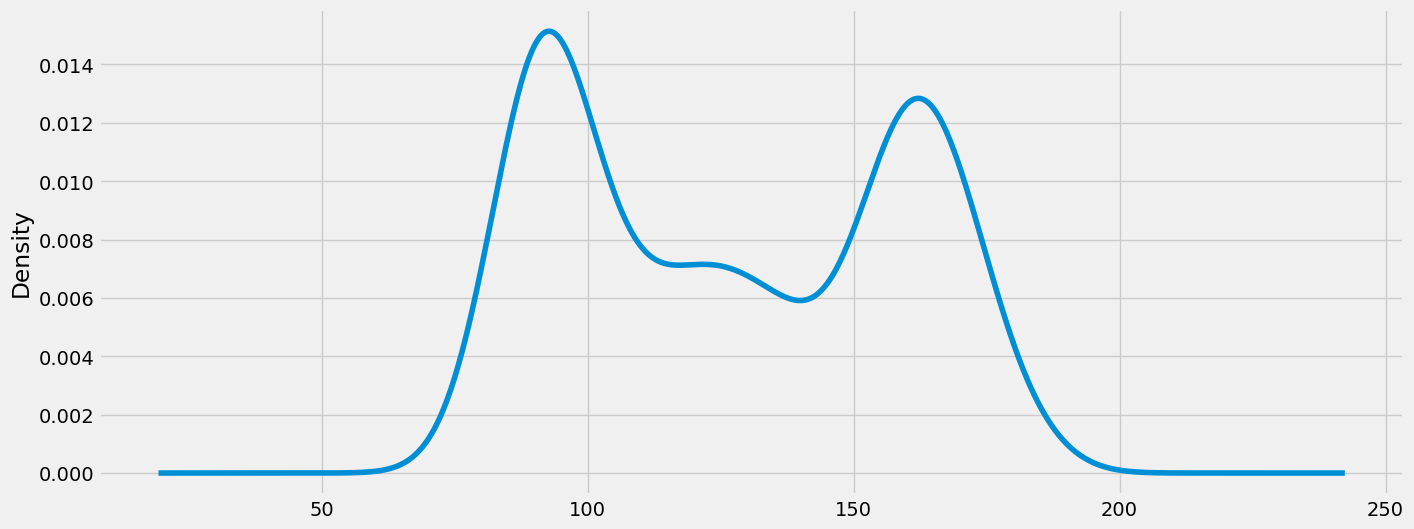

In [36]:
#Distribution of the dataset
df_amazon['Close'].plot(kind='kde')

### checking if a series is stationary or not because time series analysis only works with stationary data.

**ADF (Augmented Dickey-Fuller) Test**

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

**Null Hypothesis**: The series has a unit root (value of a =1)

**Alternate Hypothesis**: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

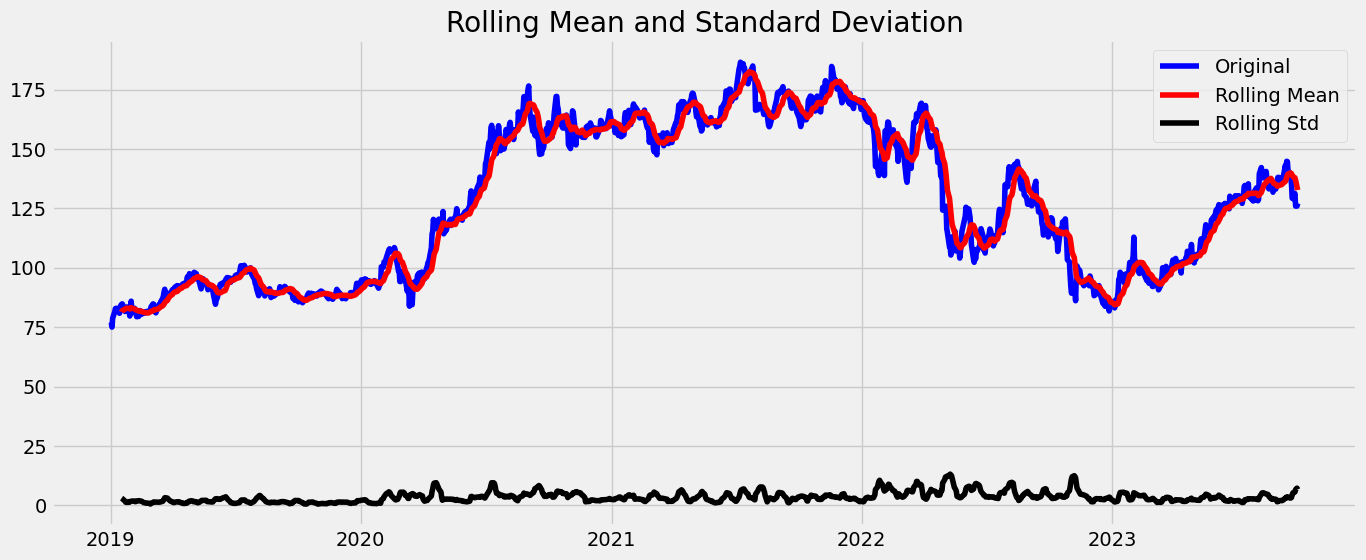

Results of dickey fuller test
Test Statistics                  -1.948524
p-value                           0.309589
No. of lags used                  0.000000
Number of observations used    1194.000000
critical value (1%)              -3.435839
critical value (5%)              -2.863964
critical value (10%)             -2.568060
dtype: float64


In [37]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_amazon['Close'])

From the graph, the behaviour of rolling mean and standard deviation are not constant over time, it suggests that the time series is **not stationary**

the p-value is greater than 0.05 so **we cannot reject the Null hypothesis**. Also, the test statistics is greater than the critical values. so the data is non-stationary.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

Trend: The increasing or decreasing value in the series.

Seasonality: The repeating short-term cycle in the series.

### Separating Trend and Seasonality from the time series

<Figure size 1500x600 with 0 Axes>

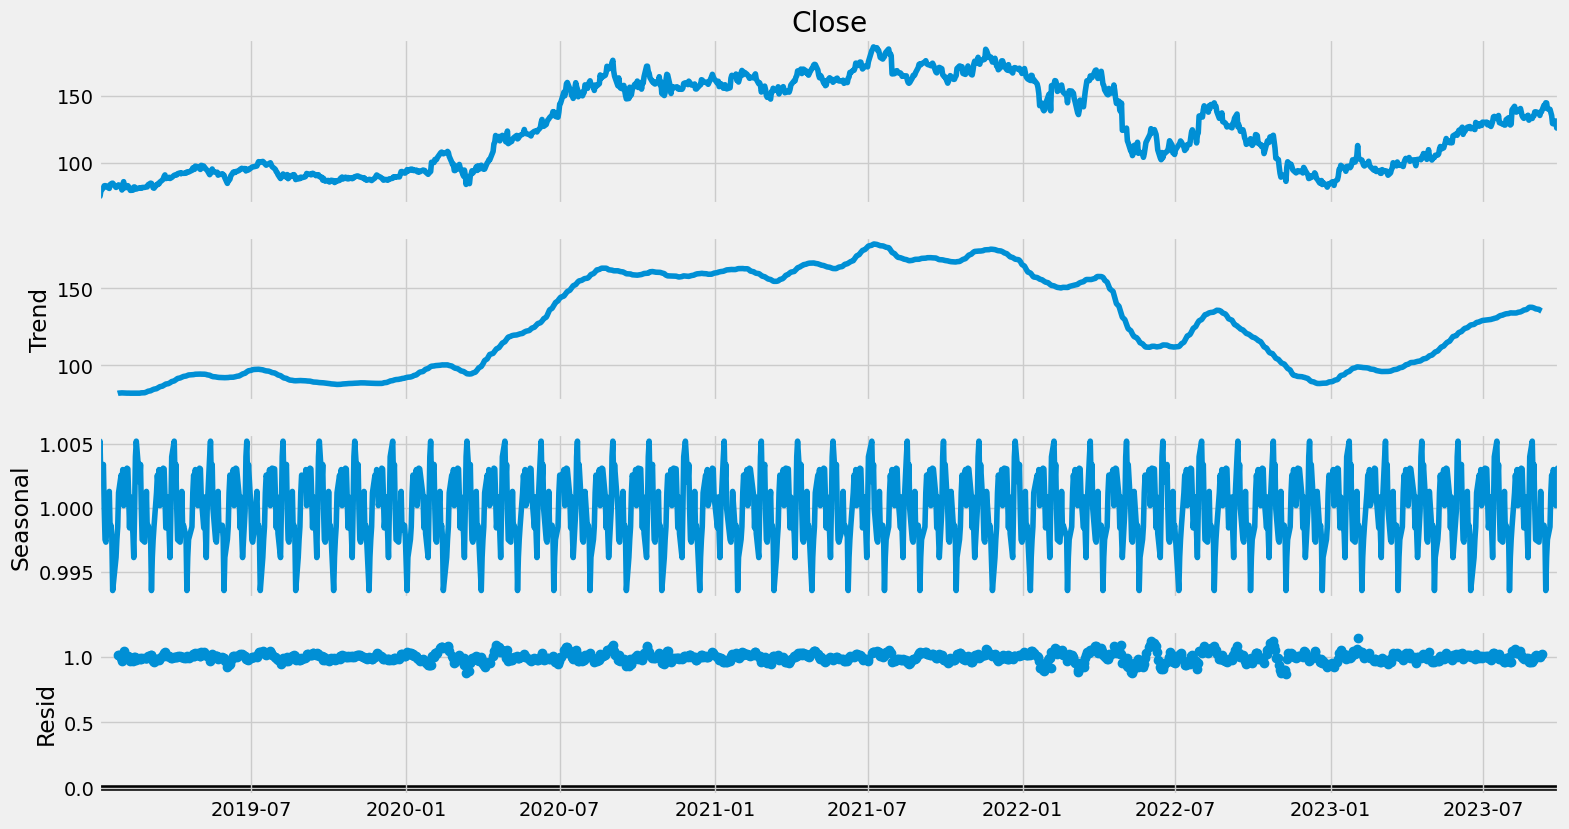

In [39]:
result = seasonal_decompose(df_amazon['Close'], model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


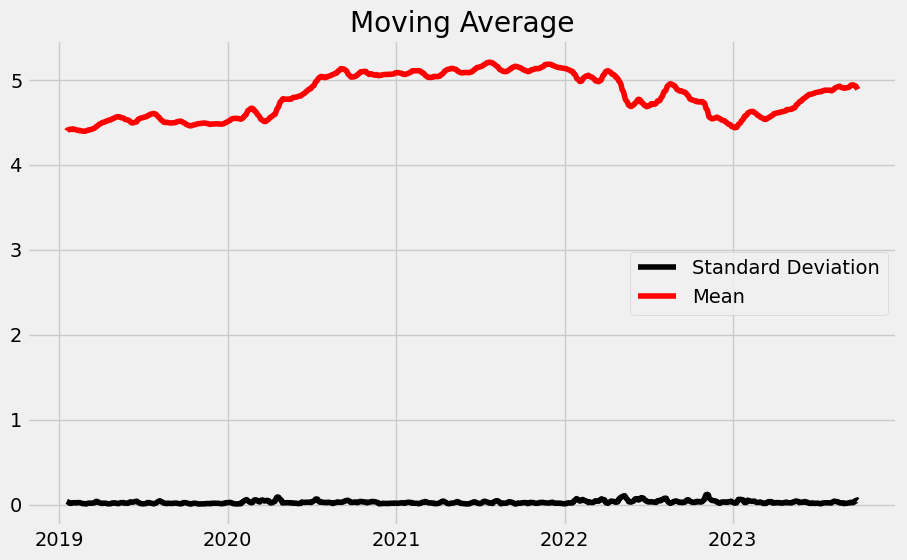

In [40]:
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_amazon['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

## ARIMA model 

We will train a ARIMA model with the closing price of the stock on the train data.

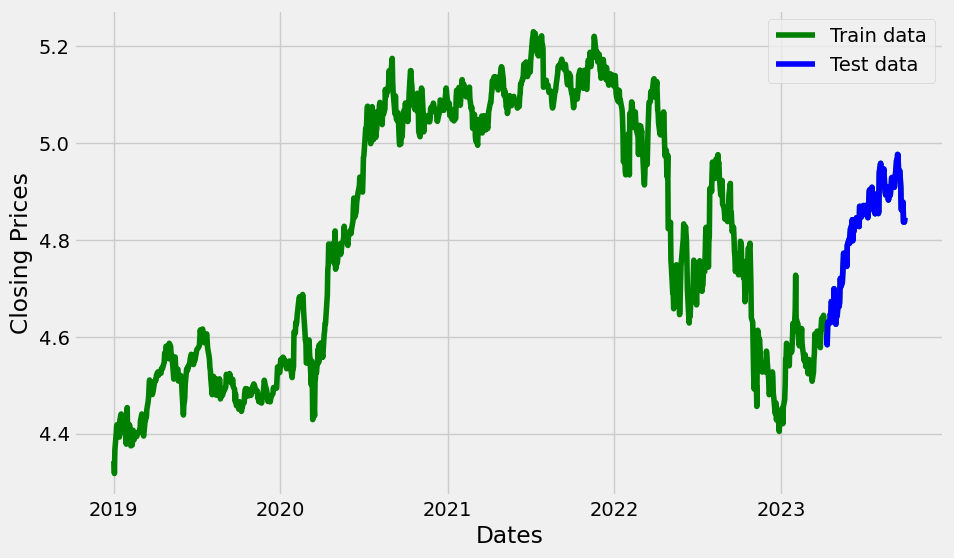

In [41]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Auto ARIMA: Automatically discover the optimal order for an ARIMA model.
The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. 

The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5079.926, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5079.165, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5079.069, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5081.832, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5076.904, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.363 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1072
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2541.916
Date:                Fri, 29 Dec 2023   AIC                          -5081.832
Time:                        10:37:43   BIC                          -5076.856
Sample:                             0   HQIC                         -5079.947
                               - 1072                                  

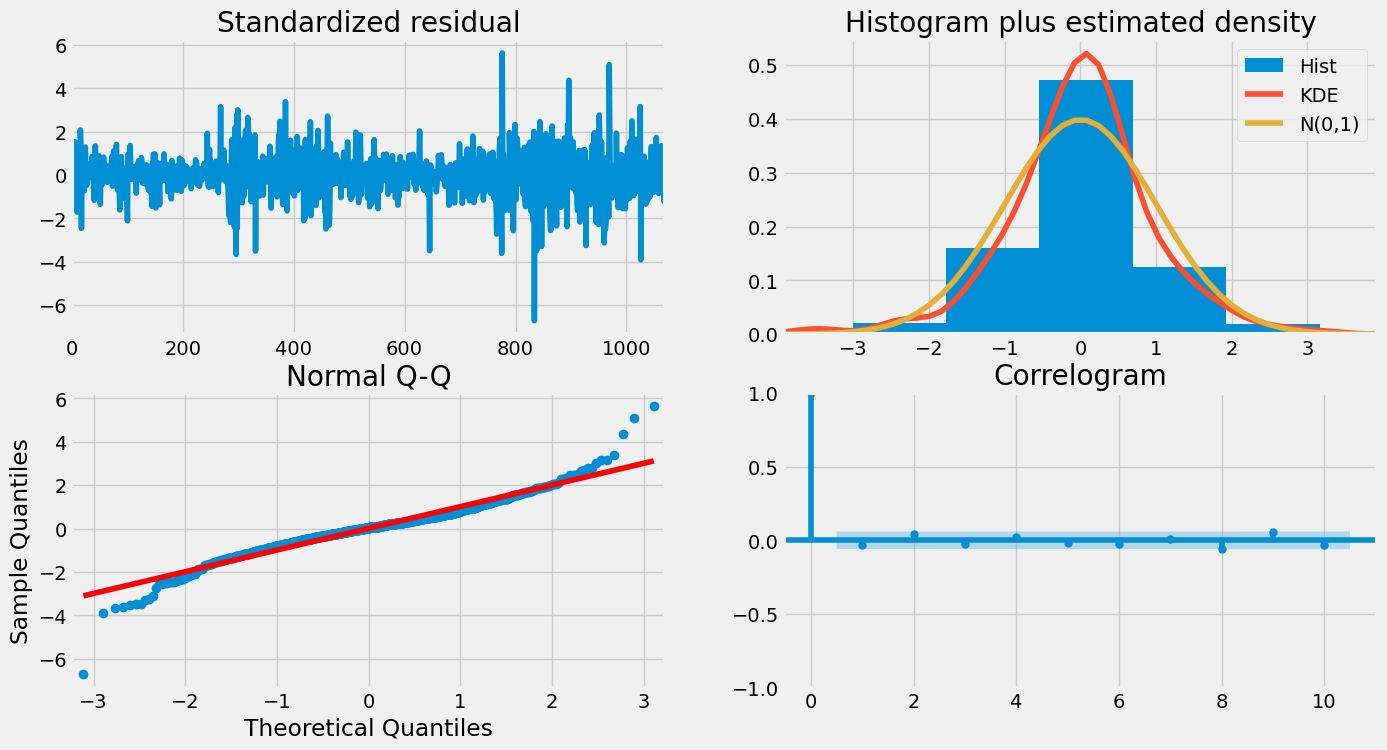

In [42]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

**Interpretation of the plots**

**Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Top Right**: The density plot suggest normal distribution with mean zero.

**Bottom left**: All the dots fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. 

Overall, it seems to be a good fit. Let’s start forecasting the stock prices.


**So the Auto ARIMA model provided the value of p,d, and q as 0, 1 and 0 respectively.**

**Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.**

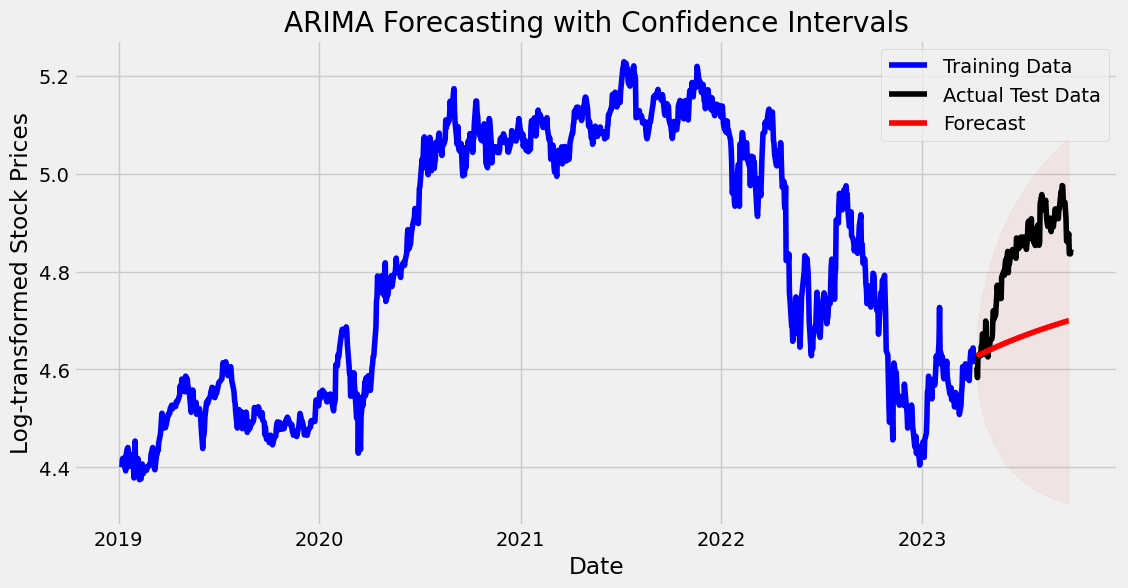

In [151]:
arima_model = ARIMA(endog=train_data.values, order=(1,0,1))
arima_result = arima_model.fit()

# Forecasting on the test set
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_index = pd.date_range(start=test_data.index[0], periods=forecast_steps, freq='B')
forecast_conf_int = pd.DataFrame(forecast.conf_int(alpha=0.05), index=forecast_index, columns=['lower', 'upper'])

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data.values, label='Training Data', color='blue')
plt.plot(test_data.index, test_data.values, label='Actual Test Data', color='black')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, forecast_conf_int.iloc[:, 0], forecast_conf_int.iloc[:, 1], color='red', alpha=0.05)

plt.xlabel('Date')
plt.ylabel('Log-transformed Stock Prices')
plt.title('Amazon Stock Price Prediction')

plt.legend()
plt.show()

In [155]:
#performace
mse = mean_squared_error(test_data, forecast.predicted_mean)
mae = mean_absolute_error(test_data, forecast.predicted_mean)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((test_data - forecast.predicted_mean) / test_data)) * 100

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}%')

Mean Squared Error (MSE): 0.0317
Mean Absolute Error (MAE): 0.1591
Root Mean Squared Error (RMSE): 0.1781
Mean Absolute Percentage Error (MAPE): 3.2655%


With a Mean Absolute Percentage Error (MAPE) of approximately 3.27%, it suggests that the ARIMA model is accurate in predicting the next 15 observations with an accuracy rate of around 96.73%.